In [1]:
import numpy as np
%matplotlib inline
import asaplib
from asaplib.data import ASAPXYZ
from asaplib.plot import Plotters
from asaplib.reducedim import Dimension_Reducers


/home/santiagovargas/anaconda3/envs/rxnrep/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
asapxyz = ASAPXYZ(
    "../../../data/complete.xyz", periodic=True
)  # periodic=False otherwise

# load the tags (optional, you can use these to annotate the structures)
tags = np.loadtxt("../../../data/ranking_complete", dtype="str")
#  import some reference order parameter for the structures
enthalpy = np.array(tags[:, 3], float)


load xyz file:  ../../../data/complete.xyz , a total of  4690 frames , a total of  91335 atoms , with elements:  [8, 22] .


In [3]:
asapxyz_test = ASAPXYZ(
    "../../../data/test_parser.xyz", periodic=True
)  # periodic=False otherwise


load xyz file:  ../../../data/test_parser.xyz , a total of  2755 frames , a total of  42470 atoms , with elements:  [1, 3, 6, 8, 9, 12] .


In [4]:
n_frames = asapxyz_test.get_num_frames()
print("number of frames: {}".format(n_frames))
energies = asapxyz_test.get_property(
    "free_energy", sbs=[i for i in range(n_frames)]
)  # this can get energy


number of frames: 2755


In [40]:
# specify the parameters
soap_spec = {
    "soap1": {
        "type": "SOAP",
        "cutoff": 4.0,
        "n": 6,
        "l": 6,
        "atom_gaussian_width": 0.5,
        "crossover": False,
        "rbf": "gto",
    }
}
soap_specific_spec = {
    "soap1": {
        "type": "SOAP",
        "cutoff": 10.0,
        "n": 6,
        "l": 6,
        "atom_gaussian_width": 0.5,
        "crossover": False,
        "rbf": "gto",
    }
}

reducer_spec = {
    "reducer1": {
        "reducer_type": "average",  # [average], [sum], [moment_average], [moment_sum]
        "element_wise": False,
    }
}

desc_spec = {
    "avgsoap": {"atomic_descriptor": soap_spec, "reducer_function": reducer_spec}
}
desc_spec_custom = {
    "avgsoap": {"atomic_descriptor": soap_specific_spec, "reducer_function": reducer_spec}
}

In [41]:
# compute atomic descriptors only
asapxyz.compute_atomic_descriptors(
    desc_spec_dict=soap_spec, sbs=[], tag="tio2-atomic", n_process=10
)
#asapxyz_test.compute_atomic_descriptors(
#    desc_spec_dict=soap_spec, sbs=[], tag="rapter-trax", n_process=10
#)

asapxyz_test.compute_atomic_descriptors(
    desc_spec_dict=soap_specific_spec, sbs=[], tag="rapter-trax", n_process=10
)


Using SOAP Descriptors ...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 3210 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 4690 out of 4690 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s


Using SOAP Descriptors ...


[Parallel(n_jobs=10)]: Done 2620 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 2736 out of 2755 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 2755 out of 2755 | elapsed:    1.0s finished


In [42]:
asapxyz_test.compute_atomic_descriptors(
    desc_spec_dict=soap_specific_spec, sbs=[], tag="rapter-trax", n_process=10
)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s


Using SOAP Descriptors ...


[Parallel(n_jobs=10)]: Done 2620 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 2736 out of 2755 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 2755 out of 2755 | elapsed:    0.9s finished


In [43]:
# if you want to retrieve the atomic descriptors computed earlier
dm_atomic = asapxyz.fetch_computed_atomic_descriptors(["soap1"])
dm_test_atomic = asapxyz_test.fetch_computed_atomic_descriptors(["soap1"])


In [31]:
print(asapxyz_test.atomic_desc[0].keys())

dict_keys(['soap1', 'soap2'])


In [44]:
# compute descriptors for the whole structures
asapxyz.compute_global_descriptors(
    desc_spec_dict=desc_spec,
    sbs=[],
    keep_atomic=False,  # set to True to keep the atomic descriptors
    tag="tio2",
    n_process=4,
)

asapxyz_test.compute_global_descriptors(
    desc_spec_dict=desc_spec_custom,
    sbs=[],
    keep_atomic=False,  # set to True to keep the atomic descriptors
    tag="rapter",
    n_process=4,
)
# can use asapxyz.fetch_computed_atomic_descriptors(['soap1']) if keep_atomic=True


Using SOAP Descriptors ...
Using Atomic_2_Global_Average reducer ...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 4690 out of 4690 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.2s


Using SOAP Descriptors ...
Using Atomic_2_Global_Average reducer ...


[Parallel(n_jobs=4)]: Done 2755 out of 2755 | elapsed:    1.3s finished


In [45]:
reduce_dict = {}
reduce_dict["kpca"] = {
    "type": "SPARSE_KPCA",
    "parameter": {
        "n_components": 10,
        "n_sparse": -1,  # no sparsification
        "kernel": {"first_kernel": {"type": "linear"}},
    },
}


In [46]:
dreducer = Dimension_Reducers(reduce_dict)
dreducer_test = Dimension_Reducers(reduce_dict)


Using kernel PCA (sparsified) ...
Using kernel PCA (sparsified) ...


In [47]:
dm = asapxyz.fetch_computed_descriptors(["avgsoap"])
proj = dreducer.fit_transform(dm)

dm = asapxyz_test.fetch_computed_descriptors(["avgsoap"])
proj_test = dreducer_test.fit_transform(dm)


Not using any sparsification
Not using any sparsification


Using scatter plot ...


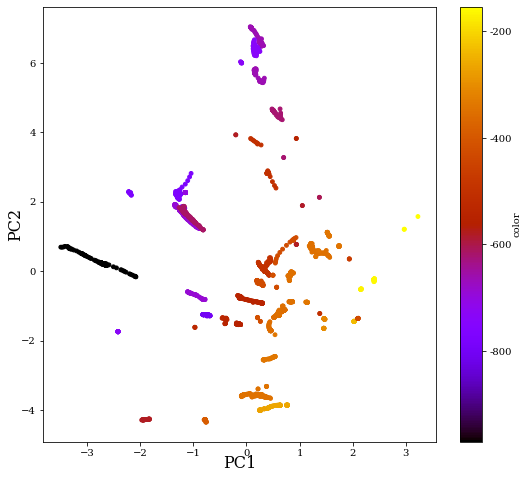

In [48]:
fig_spec = {
    "outfile": None,
    "show": False,
    "title": None,
    "size": [8 * 1.1, 8],
    "cmap": "gnuplot",
    "xlabel": "PC1",
    "ylabel": "PC2",
    "components": {
        "first_p": {
            "type": "scatter",
            "clabel": "color",
            "vmin": None,
            "vmax": None,
        }
    },
}

asap_plot = Plotters(fig_spec)

# plotcolor = enthalpy[:]
plotcolor = asapxyz_test.get_property("free_energy", sbs=[i for i in range(n_frames)])
asap_plot.plot(proj_test[:, [1, 0]], plotcolor)
# one can use asap_plot.plot(proj[:, [1,0]], plotcolor, tags) to annotate the structures using the tags


In [14]:
proj_test[:, [0, 1]].shape


(2755, 2)

In [49]:
# now we sparsify
from asaplib.compressor import Sparsifier

# mode options
n_total = proj_test[:, [0, 1]].shape[0]
modes = ["fps", "cur", "random", "sequential"]
sparser = Sparsifier(sparse_mode=modes[0])
sparse_inds = sparser.sparsify(proj_test[:], n_or_ratio=1000, sparse_param=0)


Using scatter plot ...


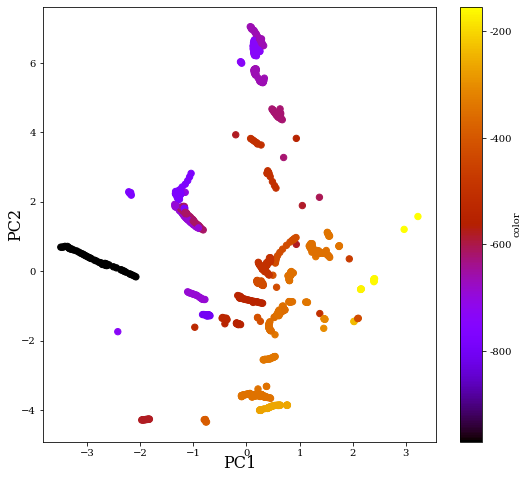

In [50]:
plotcolor = asapxyz_test.get_property("free_energy", sbs=[i for i in sparse_inds])
kde_space = proj_test[sparse_inds]
kde_space = kde_space[:, [1, 0]]
asap_plot = Plotters(fig_spec)
asap_plot.plot(kde_space, plotcolor)
